In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Preprocessing & Cleaning


In [ ]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Word cloud for data visualization
from wordcloud import WordCloud

# Regular expressions and string handling
import re
import string

# Natural Language Toolkit (NLTK) for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('punkt')           # Tokenizer models
nltk.download('punkt_tab')
nltk.download('stopwords')       # Stopword list
nltk.download('wordnet')         # Lemmatizer dictionary
nltk.download('omw-1.4')         # Lemmatizer wordnet data


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Load the dataset using Pandas
data = pd.read_csv('/content/drive/MyDrive/AI and ML/Week 8/trum_tweet_sentiment_analysis.csv')

print(data.head())

                                                text  Sentiment
0  RT @JohnLeguizamo: #trump not draining swamp b...          0
1  ICYMI: Hackers Rig FM Radio Stations To Play A...          0
2  Trump protests: LGBTQ rally in New York https:...          1
3  "Hi I'm Piers Morgan. David Beckham is awful b...          0
4  RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...          0


In [ ]:
df_text=data[['text']]
df_text.dropna()

,text
0,RT @JohnLeguizamo: #trump not draining swamp b...
1,ICYMI: Hackers Rig FM Radio Stations To Play A...
2,Trump protests: LGBTQ rally in New York https:...
3,"""Hi I'm Piers Morgan. David Beckham is awful b..."
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...
...,...
1850118,Everytime im like 'How the fuck I follow Melan...
1850119,RT @imgur: The Trump Handshake. https://t.co/R...
1850120,"""Greenspan warns Trump's policies risk inflati..."
1850121,RT @FasinatingLogic: We must also #INVESTIGATE...


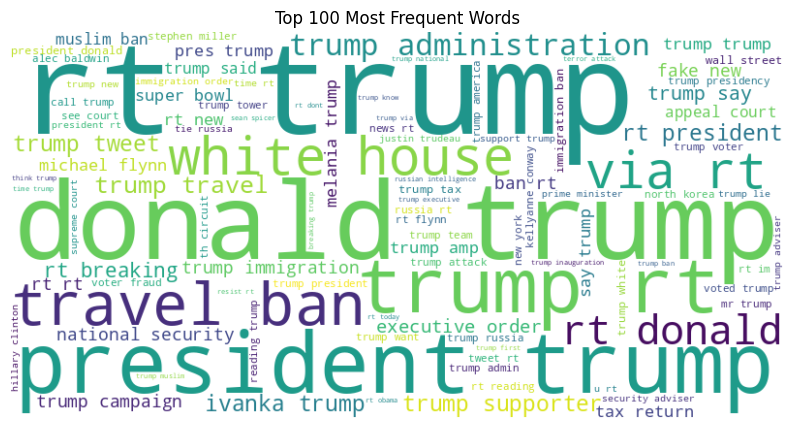

In [ ]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs, mentions, hashtags, numbers, and special characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    # Tokenize, remove stopwords, and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the dataset
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Visualize cleaned data using a word cloud
all_words = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

# 2. Tokenization & Padding


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Split data first
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'],
    data['Sentiment'],
    test_size=0.2,
    random_state=42
)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # Only on training data

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Calculate padding length (95th percentile)
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))
print(f"Padding sequences to length: {max_len}")

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Check shapes
print(f"Training data shape: {X_train_pad.shape}")
print(f"Testing data shape: {X_test_pad.shape}")

Padding sequences to length: 16
Training data shape: (1480098, 16)
Testing data shape: (370025, 16)


# 3. Model Building


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Build the Simple RNN model
rnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=50),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')  # Binary classification
])
rnn_model.build(input_shape=(None, 50))
# Compile the model
rnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary
rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

## LSTM Model

In [ ]:
from tensorflow.keras.layers import LSTM

# Build the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=50),
    LSTM(64),
    Dense(1, activation='sigmoid')  # Binary classification
])
lstm_model.build(input_shape=(None, 50))
# Compile the model
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Training & Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Train the models with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train RNN model
rnn_history = rnn_model.fit(
    X_train_pad, y_train,
    epochs=4,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop]
)

# Train LSTM model
lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=4,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stop]
)

# Evaluate RNN model
y_pred_rnn = rnn_model.predict(X_test_pad)
y_pred_rnn_classes = (y_pred_rnn > 0.5).astype(int).flatten()

print("RNN Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rnn_classes):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rnn_classes))
print("Classification Report:\n", classification_report(y_test, y_pred_rnn_classes))

# Evaluate LSTM model
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_classes = (y_pred_lstm > 0.5).astype(int).flatten()

print("LSTM Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lstm_classes):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lstm_classes))
print("Classification Report:\n", classification_report(y_test, y_pred_lstm_classes))

Epoch 1/4
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accuracy: 0.9212 - loss: 0.2002 - val_accuracy: 0.9573 - val_loss: 0.1226
Epoch 2/4
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 146s 4ms/step - accuracy: 0.9649 - loss: 0.1019 - val_accuracy: 0.9633 - val_loss: 0.1073
Epoch 3/4
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy: 0.9707 - loss: 0.0866 - val_accuracy: 0.9646 - val_loss: 0.1044
Epoch 4/4
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 142s 4ms/step - accuracy: 0.9735 - loss: 0.0790 - val_accuracy: 0.9647 - val_loss: 0.1069
Epoch 1/4
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 152s 7ms/step - accuracy: 0.9252 - loss: 0.1879 - val_accuracy: 0.9643 - val_loss: 0.1018
Epoch 2/4
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 199s 6ms/step - accuracy: 0.9692 - loss: 0.0886 - val_accuracy: 0.9700 - val_loss: 0.0876
Epoch 3/4
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 210s 7ms/step - accuracy: 0.9771 - loss: 0.0666 - val_accuracy: 0.9726 - val_loss: 0.0835
Epoch 4/4
23127/23127 ━━━━━━━━━━━━━━━━━━━━ 195s 6ms/step - accuracy: 0.

# 5. Visualization

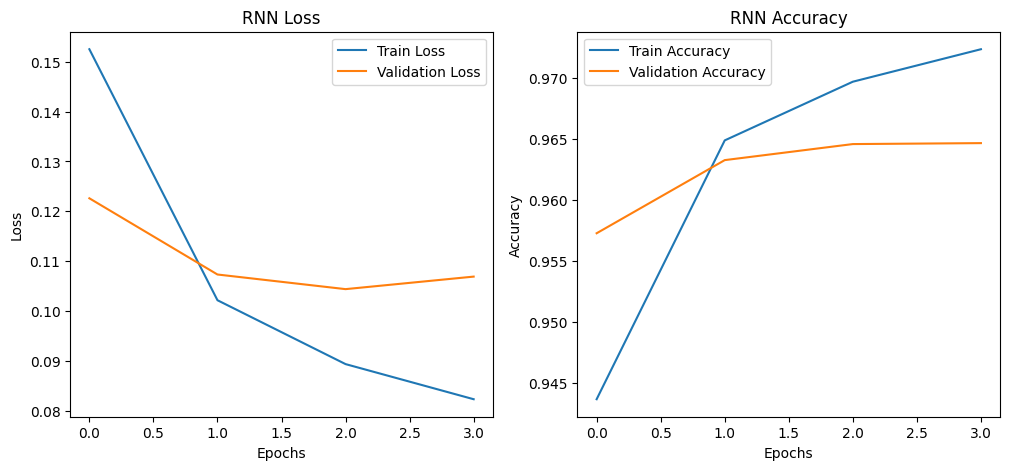

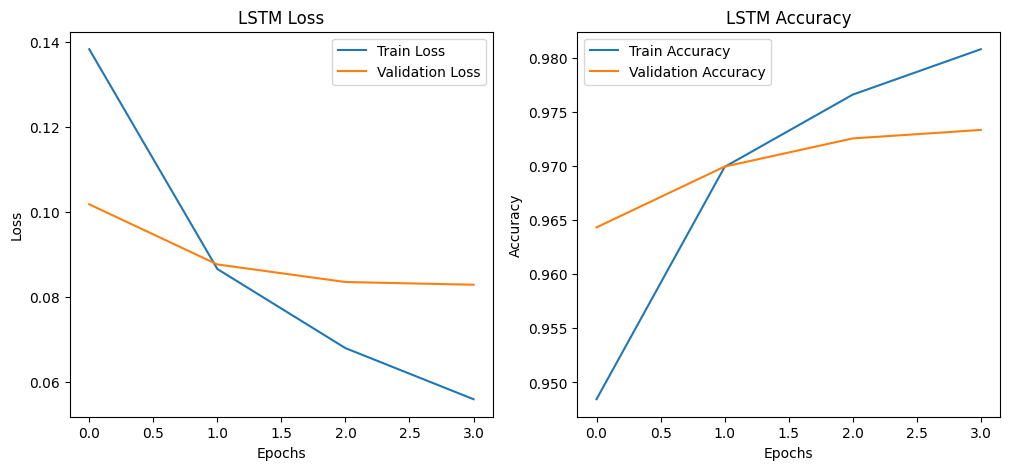

In [ ]:
# Plot training vs. validation loss and accuracy for RNN
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Repeat the same for LSTM
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import save_model

# Define the file path where you want to save the model
model_save_path_lstm = '/content/drive/MyDrive/AI and ML/Week 9/lstm_model.h5'

# Define the file path where you want to save the model
model_save_path_rnn = '/content/drive/MyDrive/AI and ML/Week 9/rnn_model.h5'

# Save the LSTM model
save_model(lstm_model, model_save_path_lstm)
save_model(rnn_model, model_save_path_rnn)

# 6. GUI for Real-Time Prediction

In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to preprocess text (same as used during training)
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs, mentions, hashtags, numbers, and special characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+|#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    # Tokenize, remove stopwords, and lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Function to predict sentiment using the trained LSTM model
def predict_sentiment_gradio(user_input):
    if not user_input.strip():
        return "Please enter a tweet for prediction!"

    # Preprocess the input text
    cleaned_input = preprocess_text(user_input)
    # Convert text to sequences using the tokenizer
    input_seq = tokenizer.texts_to_sequences([cleaned_input])
    # Apply padding to ensure uniform sequence length
    input_pad = pad_sequences(input_seq, maxlen=max_len, padding='post', truncating='post')
    # Predict sentiment using the LSTM model
    prediction = lstm_model.predict(input_pad)
    # Determine sentiment based on the prediction threshold
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    return f"Predicted Sentiment: {sentiment}"

# Create Gradio Interface
demo = gr.Interface(
    fn=predict_sentiment_gradio,  # Function to call for predictions
    inputs="text",                # Input type: text box
    outputs="text",               # Output type: text display
    title="Twitter Sentiment Predictor",  # Title of the interface
    description="Enter a tweet to predict its sentiment (Positive or Negative)."  # Description
)

# Launch the Gradio interface
demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a8ec0041ed919e295d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
